# Praca domowa 6

### Importy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

## -1. wczytanie danych

Wczytujemy dane, a dokładniej zbiór Olivetti faces.

In [2]:
data = fetch_olivetti_faces()

In [3]:
data

{'data': array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
         0.1570248 ],
        [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
         0.15289256],
        [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
         0.15289256],
        ...,
        [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
         0.19008264],
        [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
         0.60330576],
        [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
         0.38429752]], dtype=float32),
 'images': array([[[0.30991736, 0.3677686 , 0.41735536, ..., 0.37190083,
          0.3305785 , 0.30578512],
         [0.3429752 , 0.40495867, 0.43801653, ..., 0.37190083,
          0.338843  , 0.3140496 ],
         [0.3429752 , 0.41735536, 0.45041323, ..., 0.38016528,
          0.338843  , 0.29752067],
         ...,
         [0.21487603, 0.20661157, 0.2231405 , ..., 0.15289256,
     

Szybkie zapoznanie z danymi. Dowiadujemy się, że mamy zdjęcia 40 osób, po 10 dla każdej z nich. W słowniku pod kluczem 'data' mamy obrazy już w postaci listy jednowymiarowej. Jest to więc dokładnie to samo co w 'images', ale w formie bardziej przyjaznej dla podania do PCA. Jest to kolejno wiersz doklejany do wiersza, więc aby wyświetlać będziemy robili reshape i dostaniemy pożądaną macierz

In [4]:
data = data['data']

data, data_test = data[0:340], data[340:400]

Później będziemy badać RMSE, z tego powodu wydaje mi się ciekawym, aby sprawdzić działanie dla zdjęć, których wyuczony model PCA wcześniej nie widział. Będzie to można odnieść do zdjęć oryginalnych oraz tych po modyfikacjach, które również w pewien sposób będzie widział po raz pierwszy. Wydzielenie zdjęć 6 osób na zbiór testowy.

## 0. wyświetlenie wybranych zdjęć

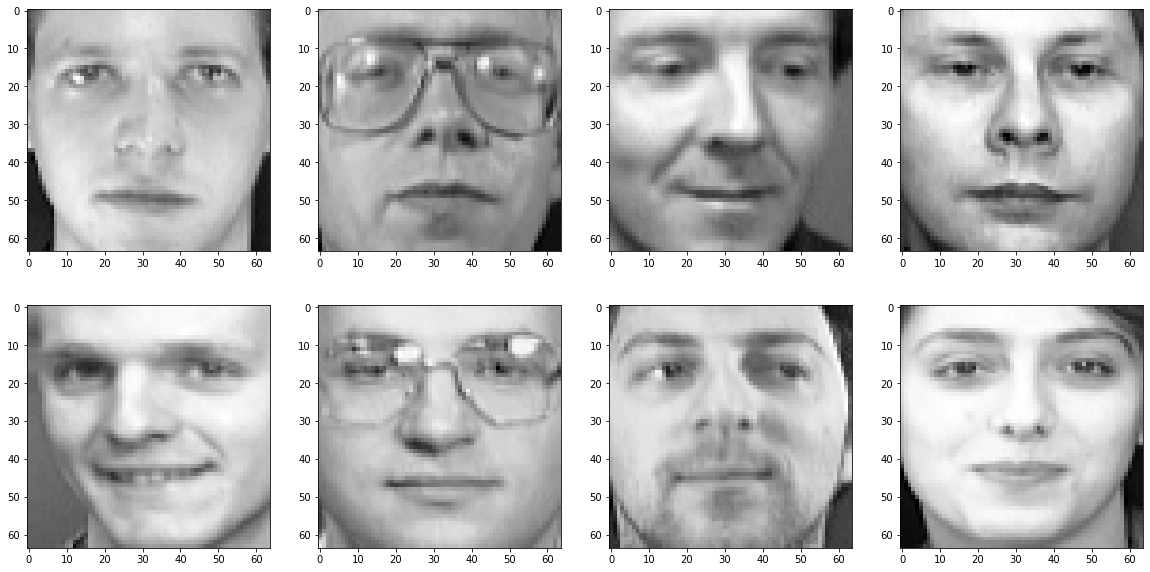

In [5]:
f = plt.figure(figsize=(20, 10))
for i in range(8):
    f.add_subplot(2, 4, i+1)
    plt.imshow(data[i*10+i].reshape(64,64), cmap='gray')
plt.show()

Powyżej zostały wyświetlone zdjęcia pierwszych 8 osób.

## 1. kompresja PCA

### wybór liczby komponentów

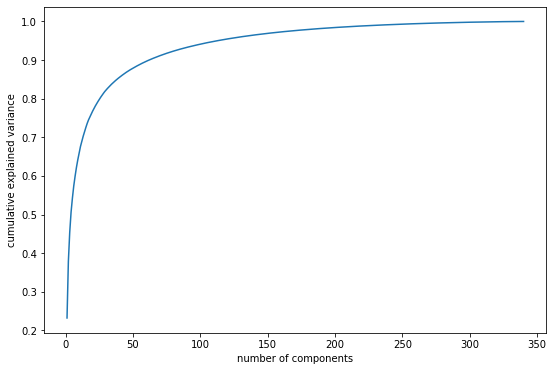

In [6]:
pca = PCA().fit(data)

plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Z wykresu możemy odczytać, że całkiem szybko wyjaśniane jest 90% wariancji. Wybierzmy zatem właśnie taką liczbę komponentów, gdzie wyjaśnimy 90% warancji licząc, że zachowamy wystarczająco dużo informacji, uzyskując względnie przystępny współczynnik kompresji.

In [7]:
n_components=0
while sum(pca.explained_variance_ratio_[0:n_components]) < 0.9:
    n_components+=1
n_components+=1#+1 wynika z tego, że wyżej w pętli slice [0:1] to pierwszy komponent

In [8]:
n_components

63

Zatem dla 63 komponentów mamy wyjaśnione 90% wariancji.

In [9]:
pca = PCA(n_components = n_components)
pca = pca.fit(data)
data_compressed = pca.transform(data)

In [10]:
sum(pca.explained_variance_ratio_)

0.901336252107285

Pora policzyć stopień kompresji.

In [11]:
data[0].size/data_compressed[0].size

65.01587301587301

Udało nam się zatem 65-krotnie zmniejszyć rozmiar zdjęć.

## 2. inverse_transform i błąd

In [12]:
"""plotowanie obok siebie fotek zmienionych i oryginalow"""

def porownaj(original, inverse):
    f = plt.figure(figsize=(20, 10))
    for i in range(4):
        f.add_subplot(2, 4, 2*i+1)
        plt.imshow(original[i*10+i].reshape(64,64), cmap='gray')
        f.add_subplot(2, 4, 2*i+2)
        plt.imshow(inverse[i*10+i].reshape(64,64), cmap='gray')
plt.show()

In [13]:
"""blad RMSE"""
mean_squared_error
def blad(original, inverse):
    wyniki=[]
    for i in range(len(original)):
        wyniki.append(mean_squared_error(original[i], inverse[i], squared=False))
    
    return wyniki

Dokonajmy odwrotnej transformacji wcześniejszych zdjęć.

In [14]:
data_inverse=pca.inverse_transform(data_compressed)

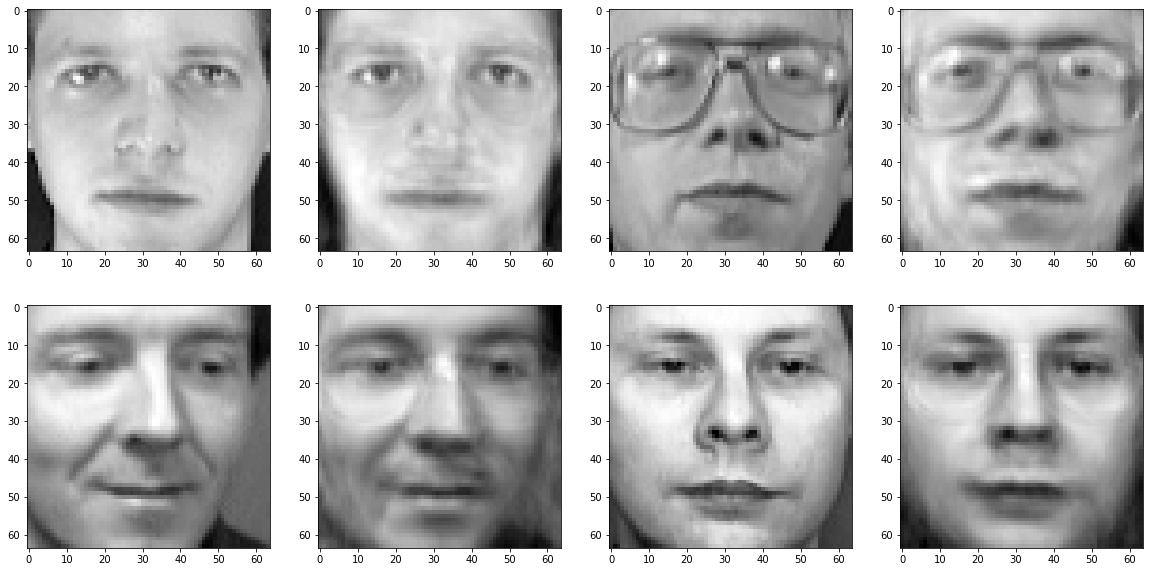

In [15]:
porownaj(data, data_inverse)

Dosyć ciekawe jest umieszczanie delikatnych obrysów okularów na odzyskiwanych zdjęciach.

Srednia wartosc RMSE to 0.042569003999233246


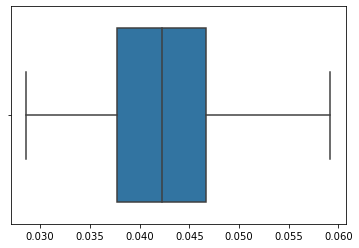

In [16]:
wyniki = blad(data, data_inverse)

sns.boxplot(x=wyniki)
print(f"Srednia wartosc RMSE to {np.mean(wyniki)}")

Może teraz powtórzmy eksperyment dla obrazów, których model wcześniej nie wiedział.

In [17]:
data_test_transformed = pca.transform(data_test)
data_test_inversed = pca.inverse_transform(data_test_transformed)

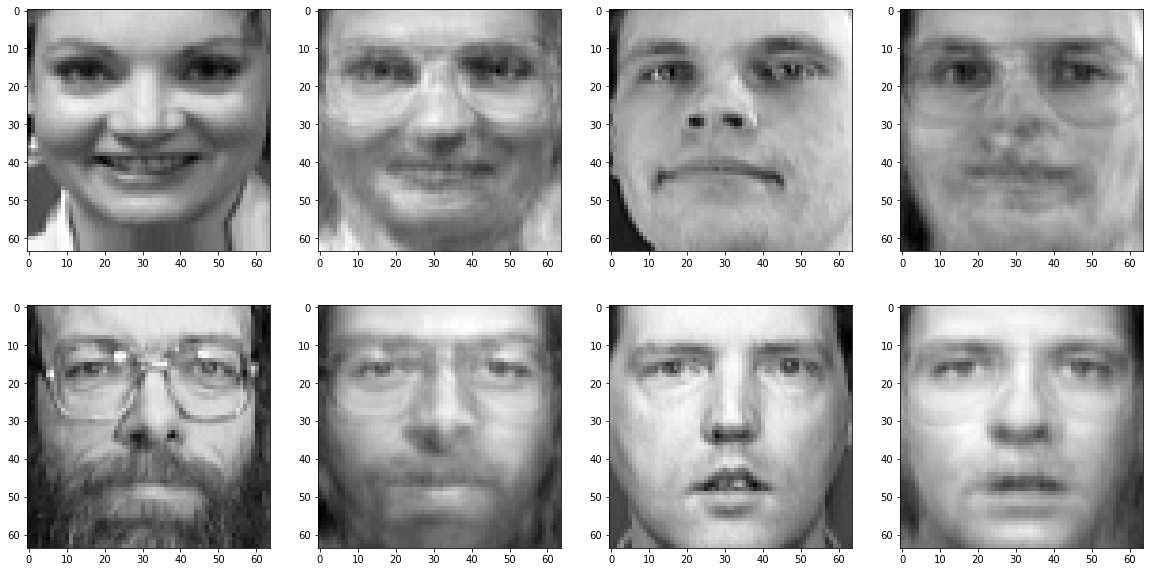

In [18]:
porownaj(data_test, data_test_inversed)

Srednia wartosc RMSE to 0.06683541089296341


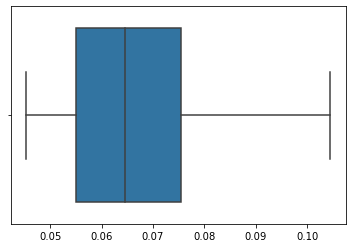

In [19]:
wyniki2 = blad(data_test, data_test_inversed)

sns.boxplot(x=wyniki2)
print(f"Srednia wartosc RMSE to {np.mean(wyniki2)}")

In [20]:
print(f"Różnica w wartościach RMSE {np.mean(wyniki2) - np.mean(wyniki):.16f}")

Różnica w wartościach RMSE 0.0242664068937302


Zgodnie z tym, jak można było przypuszczać, wynik dla nowego zestawu zdjęć wyszedł gorszy. Wizualnie również widać większe braki w dokładności odtworzenia zdjęć.

## 3. i 4. dokonujemy modyfikacji i oceniamy wyniki

### a) symetria

In [21]:
#przygotowanie zdjęć z symetrią
data_symetria = data.copy()
for i in range(len(data_symetria)):
    lista = data_symetria[i]
    lista = lista.reshape(64, 64)
    for x in range(64):
        lista[x] = lista[x][::-1]
    lista = lista.reshape(1,4096)
    data_symetria[i] = lista

data_symetria_t = pca.transform(data_symetria)
data_symetria_i = pca.inverse_transform(data_symetria_t)

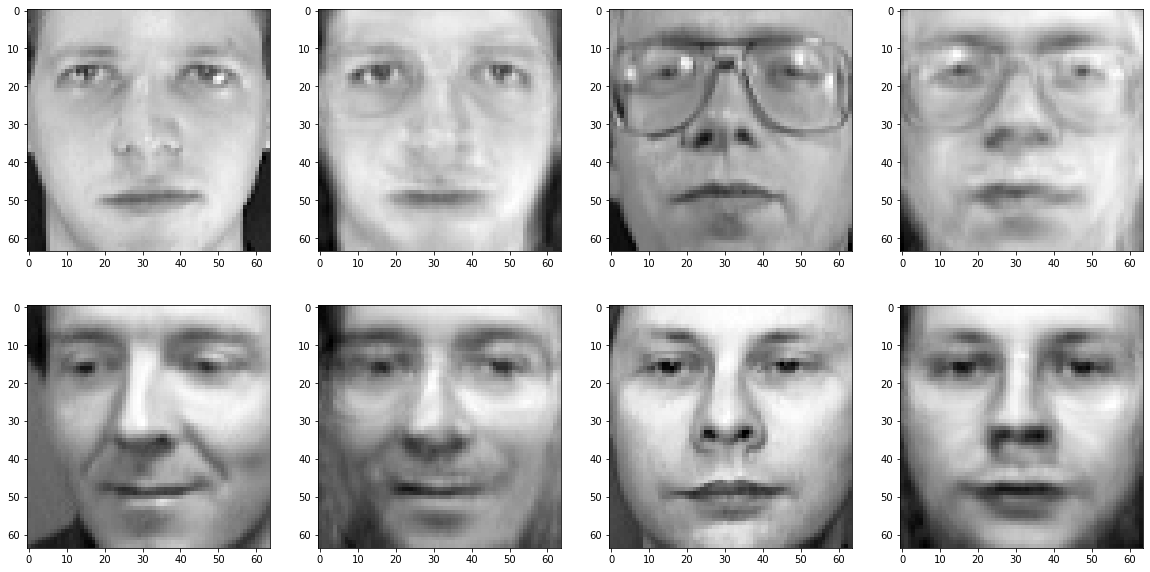

In [22]:
porownaj(data_symetria, data_symetria_i)

Powyżej zestawienie zdjęć po zaaplikowanej symetrii i odtworzeniu z pomocą PCA

Srednia wartosc RMSE to 0.06326074153184891


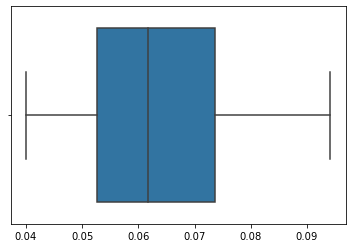

In [23]:
wyniki_symetria = blad(data_symetria, data_symetria_i)

sns.boxplot(x=wyniki_symetria)
print(f"Srednia wartosc RMSE to {np.mean(wyniki_symetria)}")

## Uwaga:

Błąd się zwiększył. Proponuję jednak, aby skupić się na wynikach zbiorczo na sam koniec gdzie porównywanie będzie znacznie ułatwione. Teraz można bardziej oglądać wizualne zmiany i je sobie podziwiać. Na koniec wyprintujemy też boxploty i wyciągniemy jakieś wnioski.

### na zbiorze testowym

In [24]:
data_symetria_test = data_test.copy()
for i in range(len(data_symetria_test)):
    lista = data_symetria_test[i]
    lista = lista.reshape(64, 64)
    for x in range(64):
        lista[x] = lista[x][::-1]
    lista = lista.reshape(1,4096)
    data_symetria_test[i] = lista

data_symetria_test_t = pca.transform(data_symetria_test)
data_symetria_test_i = pca.inverse_transform(data_symetria_test_t)

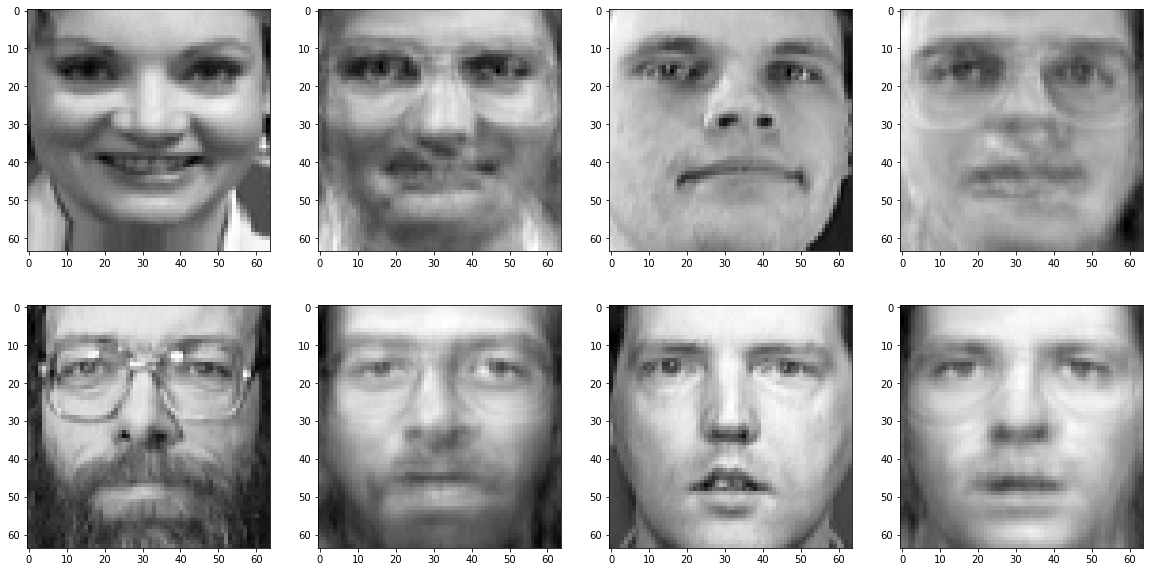

In [25]:
porownaj(data_symetria_test, data_symetria_test_i)

Srednia wartosc RMSE to 0.06813666224479675


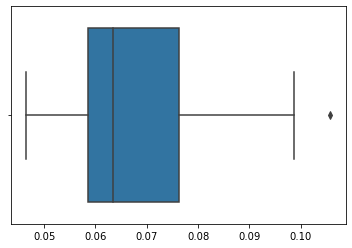

In [26]:
wyniki_symetria_test = blad(data_symetria_test, data_symetria_test_i)

sns.boxplot(x=wyniki_symetria_test)
print(f"Srednia wartosc RMSE to {np.mean(wyniki_symetria_test)}")

### b) obrócenie fotki o 90 stopni

In [27]:
#przygotowanie zdjęć obroconych
data_obrocone = data.copy()
for i in range(len(data_obrocone)):
    lista = data_obrocone[i]
    lista = lista.reshape(64, 64)

    lista = lista.transpose()
    
    lista = lista.reshape(1,4096)
    data_obrocone[i] = lista

data_obrocone_t = pca.transform(data_obrocone)
data_obrocone_i = pca.inverse_transform(data_obrocone_t)

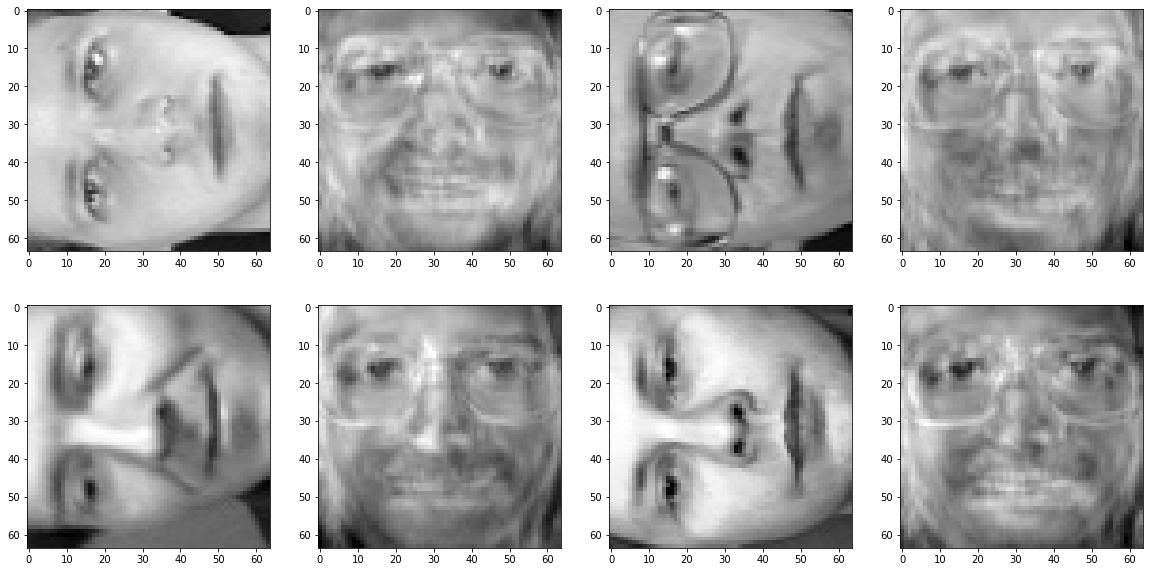

In [28]:
porownaj(data_obrocone, data_obrocone_i)

Srednia wartosc RMSE to 0.10460250079631805


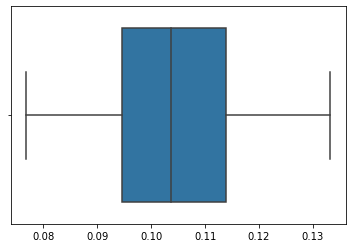

In [29]:
wyniki_obrocone = blad(data_obrocone, data_obrocone_i)

sns.boxplot(x=wyniki_obrocone)
print(f"Srednia wartosc RMSE to {np.mean(wyniki_obrocone)}")

#### analogicznie na testowym

In [30]:
#przygotowanie zdjęć obroconych
data_obrocone_test = data_test.copy()
for i in range(len(data_obrocone_test)):
    lista = data_obrocone_test[i]
    lista = lista.reshape(64, 64)

    lista = lista.transpose()
    
    lista = lista.reshape(1,4096)
    data_obrocone_test[i] = lista

data_obrocone_test_t = pca.transform(data_obrocone_test)
data_obrocone_test_i = pca.inverse_transform(data_obrocone_test_t)

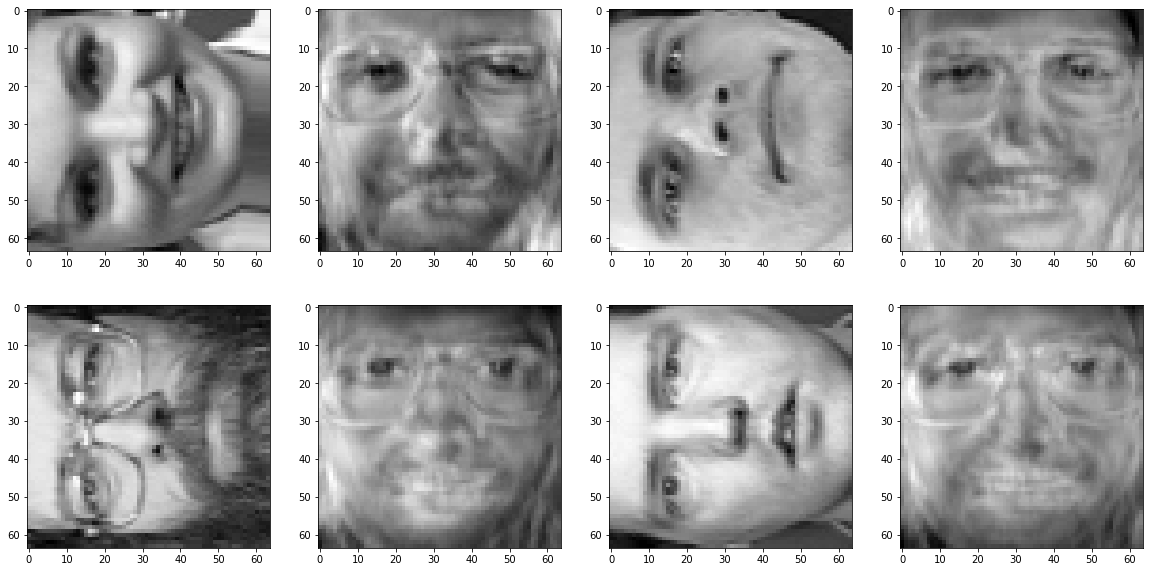

In [31]:
porownaj(data_obrocone_test, data_obrocone_test_i)

Srednia wartosc RMSE to 0.10754312574863434


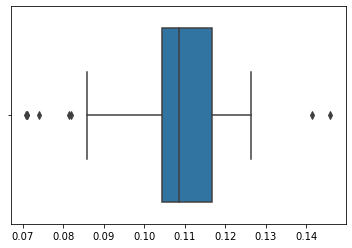

In [32]:
wyniki_obrocone_test = blad(data_obrocone_test, data_obrocone_test_i)

sns.boxplot(x=wyniki_obrocone_test)
print(f"Srednia wartosc RMSE to {np.mean(wyniki_obrocone_test)}")

### c) rozjaśnianie

In [33]:
data_rozjasnione = data.copy()
for i in range(len(data_rozjasnione)):
    obrazek = data_rozjasnione[i]
    for j in range(len(obrazek)):
        obrazek[j]=min(obrazek[j]+0.3, 1)
    data_rozjasnione[i] = obrazek
    
data_rozjasnione_t = pca.transform(data_rozjasnione)
data_rozjasnione_i = pca.inverse_transform(data_rozjasnione_t)

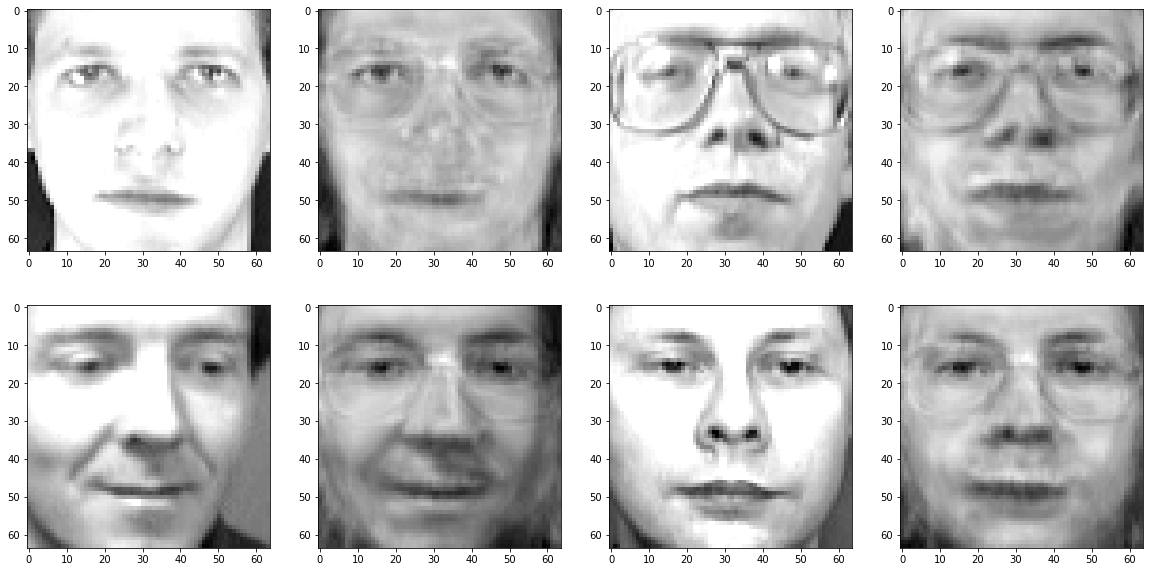

In [34]:
porownaj(data_rozjasnione, data_rozjasnione_i)

Srednia wartosc RMSE to 0.053261250257492065


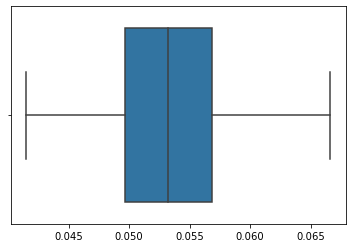

In [35]:
wyniki_rozjasnione = blad(data_rozjasnione, data_rozjasnione_i)

sns.boxplot(x=wyniki_rozjasnione)
print(f"Srednia wartosc RMSE to {np.mean(wyniki_rozjasnione)}")

#### znów analogicznie na testowym

In [36]:
data_rozjasnione_test = data_test.copy()
for i in range(len(data_rozjasnione_test)):
    obrazek = data_rozjasnione_test[i]
    for j in range(len(obrazek)):
        obrazek[j]=min(obrazek[j]+0.3, 1)
    data_rozjasnione_test[i] = obrazek
    
data_rozjasnione_test_t = pca.transform(data_rozjasnione_test)
data_rozjasnione_test_i = pca.inverse_transform(data_rozjasnione_test_t)

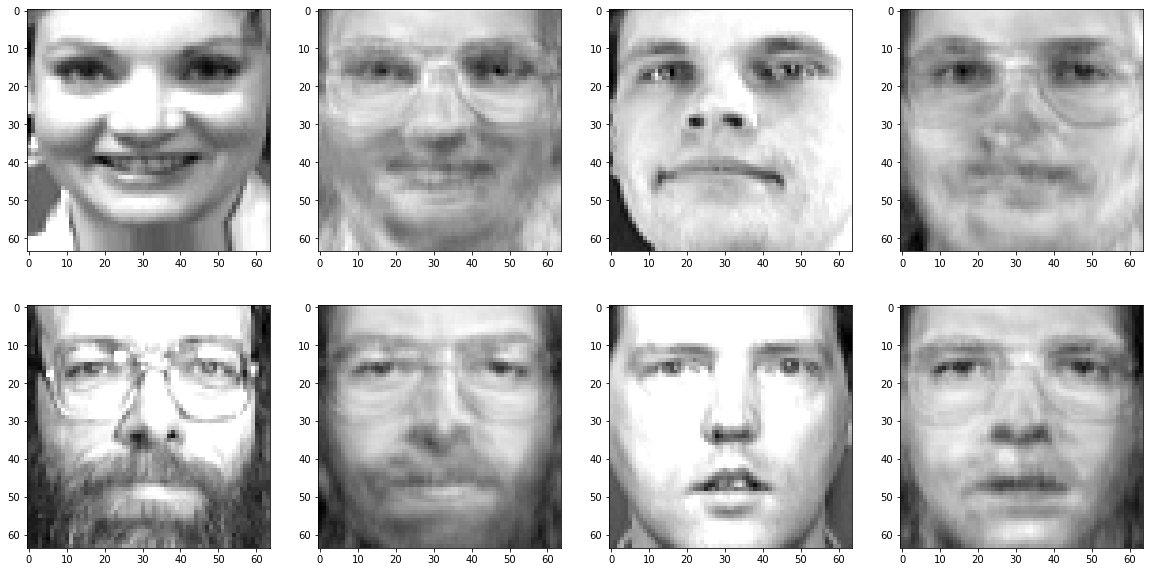

In [37]:
porownaj(data_rozjasnione_test, data_rozjasnione_test_i)

Srednia wartosc RMSE to 0.06852921098470688


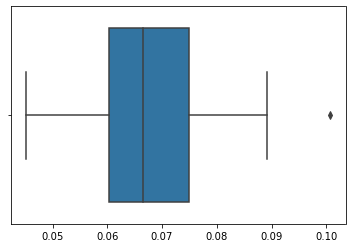

In [38]:
wyniki_rozjasnione_test = blad(data_rozjasnione_test, data_rozjasnione_test_i)

sns.boxplot(x=wyniki_rozjasnione_test)
print(f"Srednia wartosc RMSE to {np.mean(wyniki_rozjasnione_test)}")

### d) histogram equalization

In [39]:
from skimage.exposure import equalize_hist

In [40]:
data_hist = data.copy()
for i in range(len(data_hist)):
    lista = data_hist[i]
    lista = equalize_hist(lista)
    data_hist[i] = lista

data_hist_t = pca.transform(data_hist)
data_hist_i = pca.inverse_transform(data_hist_t)

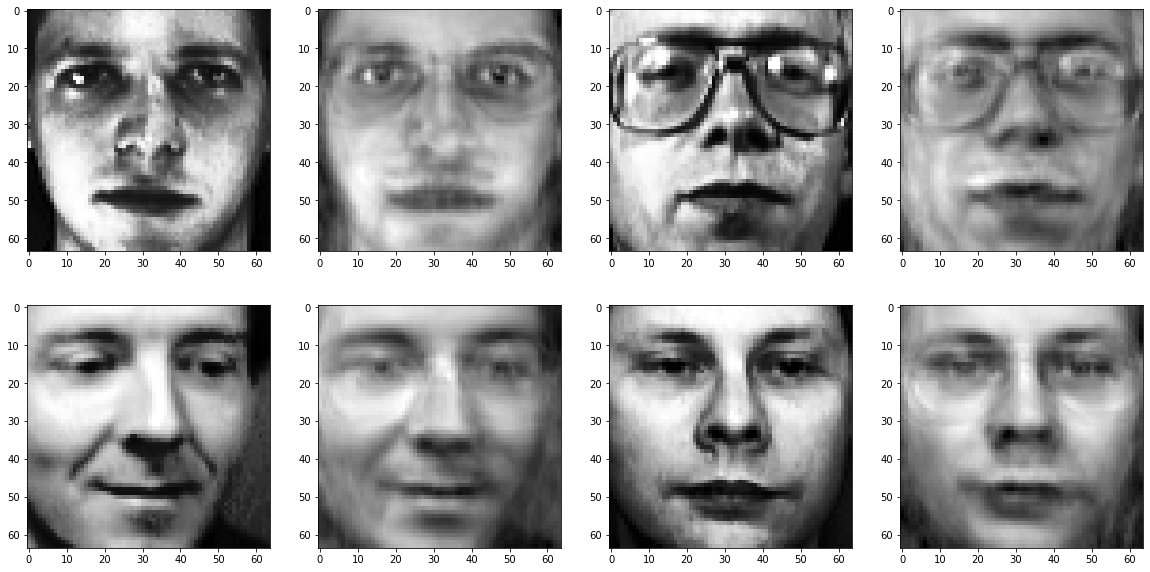

In [41]:
porownaj(data_hist, data_hist_i)

Srednia wartosc RMSE to 0.0920153558254242


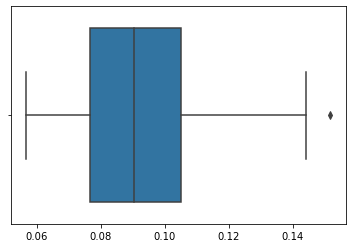

In [42]:
wyniki_hist = blad(data_hist, data_hist_i)

sns.boxplot(x=wyniki_hist)
print(f"Srednia wartosc RMSE to {np.mean(wyniki_hist)}")

#### analogicznie na test

In [43]:
data_hist_test = data_test.copy()
for i in range(len(data_hist_test)):
    lista = data_hist_test[i]
    lista = equalize_hist(lista)
    data_hist_test[i] = lista

data_hist_test_t = pca.transform(data_hist_test)
data_hist_test_i = pca.inverse_transform(data_hist_test_t)

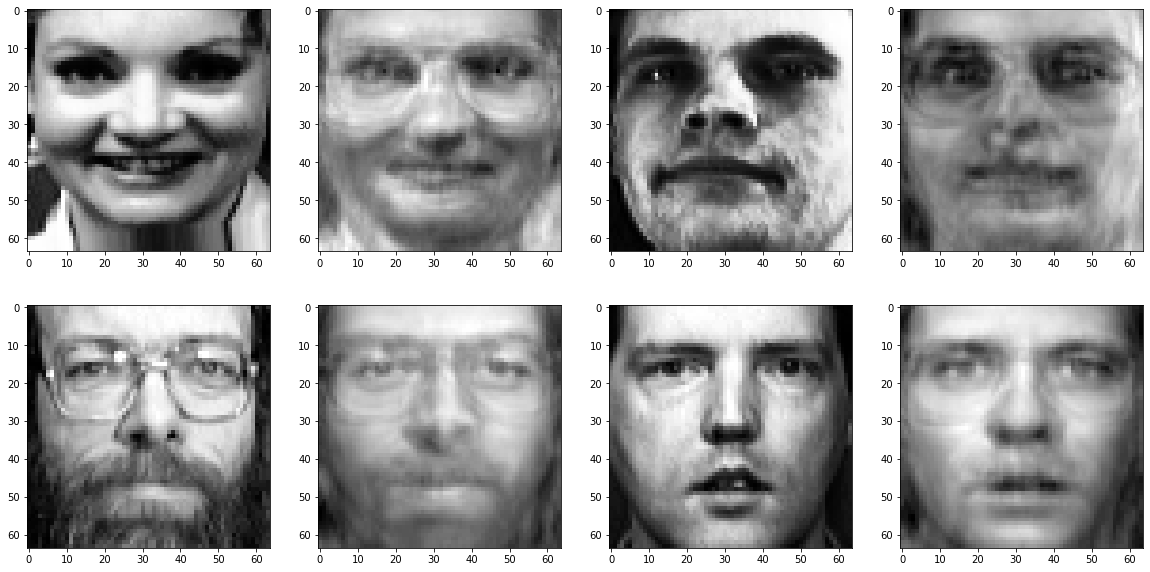

In [44]:
porownaj(data_hist_test, data_hist_test_i)

Srednia wartosc RMSE to 0.12017295509576797


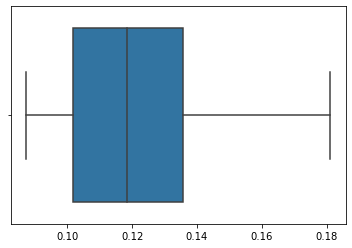

In [45]:
wyniki_hist_test = blad(data_hist_test, data_hist_test_i)

sns.boxplot(x=wyniki_hist_test)
print(f"Srednia wartosc RMSE to {np.mean(wyniki_hist_test)}")

## Wyniki

In [46]:
wynikiTraining = {'Oryginal':wyniki,
                  'Rozjasnione':wyniki_rozjasnione,
                  'Symetria': wyniki_symetria,
                  'Hist_eq':wyniki_hist,
                  'Obrocone':wyniki_obrocone}

wynikiTraining = pd.DataFrame(data=wynikiTraining)
wynikiTraining

,Oryginal,Rozjasnione,Symetria,Hist_eq,Obrocone
0,0.042627,0.052923,0.047302,0.130709,0.107682
1,0.044308,0.053726,0.057288,0.116104,0.096392
2,0.043265,0.055492,0.058035,0.135362,0.114482
3,0.038480,0.048466,0.051279,0.081463,0.095830
4,0.047283,0.055045,0.060330,0.107780,0.101266
...,...,...,...,...,...
335,0.040851,0.049852,0.076446,0.111258,0.093015
336,0.041713,0.052868,0.087586,0.093970,0.105245
337,0.037549,0.052237,0.081712,0.103519,0.098329
338,0.033693,0.048561,0.082630,0.097526,0.097980


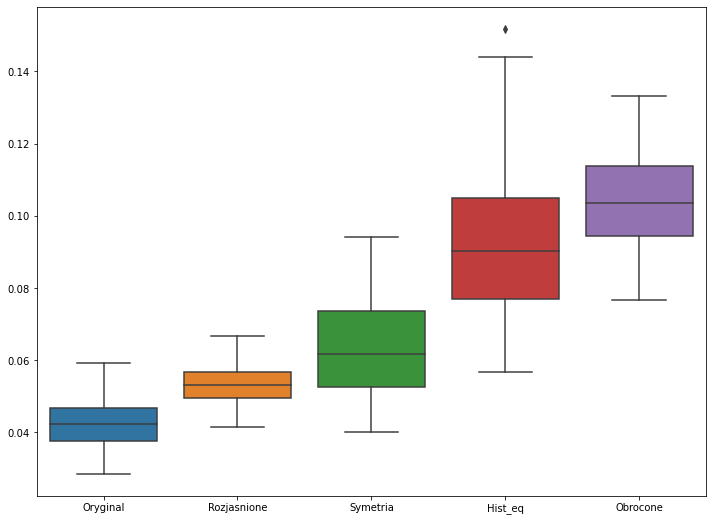

In [47]:
plt.figure(figsize=(12,9))
ax = sns.boxplot(data=wynikiTraining)

Z posortowanych względem średniej boxplotów, możemy wyczytać wiele informacji. Po pierwsze możemy zobaczyć wpływ na wartość RMSE poszczególnych operacji wykonanych na zdjęciach. Wartość dla danych oryginalnych była w okolicach 0.04 i rosła osiągając największą wartość dla zdjęć obróconych o 90 stopni. Może to też poniekąd znaleźć uzasadnienie w wizualnych reprezentacjach obrazów. Zdjęcia twarzy po odwronej transformacji były w pionie co mocno odbiegało od formy wejściowej.

In [48]:
wynikiTraining.mean(axis=0)

Oryginal       0.042569
Rozjasnione    0.053261
Symetria       0.063261
Hist_eq        0.092015
Obrocone       0.104603
dtype: float64

Powyżej dodatkowo obliczone dokładne wartości średnich.

#### Teraz test set

In [49]:
wynikiTest = {'Oryginal':wyniki2,
                  'Rozjasnione':wyniki_rozjasnione_test,
                  'Symetria': wyniki_symetria_test,
                  'Hist_eq':wyniki_hist_test,
                  'Obrocone':wyniki_obrocone_test}

wynikiTest = pd.DataFrame(data=wynikiTest)
wynikiTest

,Oryginal,Rozjasnione,Symetria,Hist_eq,Obrocone
0,0.074480,0.076926,0.078206,0.135656,0.121733
1,0.081028,0.084947,0.083377,0.145097,0.117605
2,0.059885,0.065485,0.062289,0.117927,0.105848
3,0.066036,0.071417,0.068473,0.119027,0.117079
4,0.058642,0.062629,0.058524,0.096114,0.105998
5,0.072487,0.076786,0.074314,0.119810,0.110968
6,0.074430,0.075883,0.077568,0.119930,0.108178
7,0.077238,0.083355,0.076840,0.127843,0.113266
8,0.066434,0.070125,0.062539,0.109811,0.111035
9,0.066490,0.071132,0.067303,0.109061,0.118446


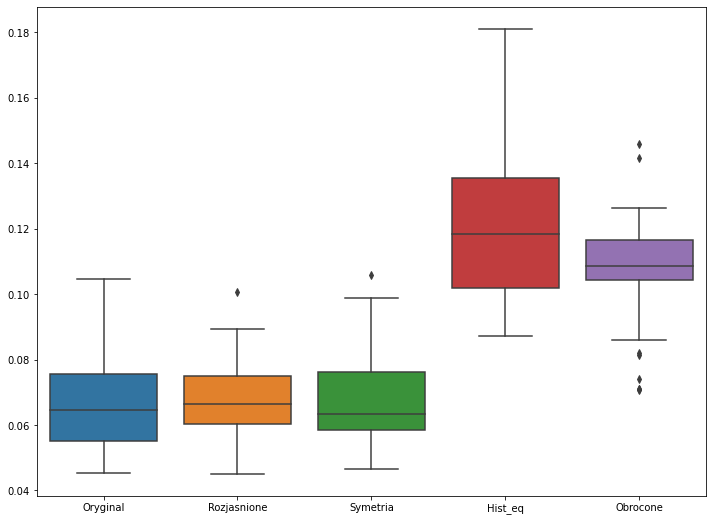

In [50]:
plt.figure(figsize=(12,9))
ax = sns.boxplot(data=wynikiTest)

Po pierwsze, warto zwrócić uwagę na podniesione RMSE do 0.6 dla zdjęć oryginalnych dla zbioru testowego. Na wykresie można zauważyć również, że średnie są dużo bardziej zbliżone dla różnego typu modyfikacji w stosunku do zbioru treningowego.

In [51]:
wynikiTest.mean(axis=0)

Oryginal       0.066835
Rozjasnione    0.068529
Symetria       0.068137
Hist_eq        0.120173
Obrocone       0.107543
dtype: float64

## PCA a wykrywanie anomalii

Wnioski zakładając, że mamy klasyfikator wytrenowany tylko do tego stopnia, ale też nie wiem czy można by się spodziewać czegoś znacznie różnego przy większym datasetcie.

Gdybyśmy mieli tylko zdjęcia, które klasyfikator już widział, to na podstawie RMSE, moglibyśmy z pewnym prawdopodobieństwem przypisywać zdjęcie do pewnej klasy. Jednoznaczne przypisanie byłoby utrudnione, boxploty się przenikają dosyć mocno.

Moglibyśmy z użyciem tego probować wskazywać, które zdjęcie zostało dodane do zbioru i nie pochodzi z niego oryginalnie. Patrząc jednak na wariancję i średnią dla wyniku (porównujemy dane beztransformacji dla train i test), byłoby to mocne przybliżenie.

Gdybyśmy tego chceili używać dla nowych danych rozróżnienie pewnych modyfikacji wydaje się niemożliwe lub będzie bardzo słabej jakości. W grę nie wchodzi wykrywanie jakichś drobnych anomalii a prędzej coś w stylu radykalnego obrócenia zdjęcia o kąt 90*.